# Deflection maps

In [1]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2
import palettable
from astropy.cosmology import Planck15
from astropy.convolution import convolve, Gaussian2DKernel
import pickle

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.profiles import MassProfileNFW, MassProfileSIE
from simulation.population_sim import SubhaloPopulation
from simulation import prior
from simulation.lensing_sim import LensingSim


In [2]:
paper_settings.setup()

## Settings

In [3]:
n_images = 20
f_sub = 0.05
beta = -1.9

## "Simulator"

In [4]:
theta_1d =  np.linspace(-3.2, 3.2, 32)
theta_x, theta_y = np.meshgrid(theta_1d, theta_1d)

In [5]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [6]:
def _mag_to_flux(mag, mag_zp):
    """
    Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
    """
    return 10 ** (-0.4 * (mag - mag_zp))

In [7]:
def _convolve_psf(image, fwhm_psf=0.18, pixel_size=0.1):
    """
    Convolve input map of pixel_size with Gaussian PSF of with FWHM `fwhm_psf`
    """
    sigma_psf = fwhm_psf / 2 ** 1.5 * np.sqrt(np.log(2))  # Convert FWHM to standard deviation
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    return convolve(image, kernel)

In [8]:
def lensing(ps, theta_E, z_l, theta_x_0=0., theta_y_0=0., theta_s_e = 0.2, z_s = 1.5, mag_s = 23.0, mag_zero=25.5, mag_iso=22.5, n_xy=64, pixel_size=0.1, q=1, exposure=1610.0, fwhm_psf=0.18):
    S_tot = _mag_to_flux(mag_s, mag_zero)
    f_iso = _mag_to_flux(mag_iso, mag_zero)
    
    coordinate_limit = pixel_size * n_xy / 2.0

    # Set host properties. Host assumed to be at the center of the image.
    hst_param_dict = {"profile": "SIE", "theta_x_0": 0.0, "theta_y_0": 0.0, "theta_E": theta_E, "q": q}

    lens_list = [hst_param_dict]

    # Set subhalo properties
    for i_sub, (m, theta_x, theta_y) in enumerate(zip(ps.m_sample, ps.theta_x_sample, ps.theta_y_sample)):
        c = MassProfileNFW.c_200_SCP(m)
        r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
        sub_param_dict = {"profile": "NFW", "theta_x_0": theta_x, "theta_y_0": theta_y, "M_200": m, "r_s": r_s, "rho_s": rho_s}
        lens_list.append(sub_param_dict)

    # Set source properties
    src_param_dict = {"profile": "Sersic", "theta_x_0": theta_x_0, "theta_y_0": theta_y_0, "S_tot": S_tot, "theta_e": theta_s_e, "n_srsc": 1}

    # Set observation and global properties
    observation_dict = {
        "n_x": n_xy,
        "n_y": n_xy,
        "theta_x_lims": (-coordinate_limit, coordinate_limit),
        "theta_y_lims": (-coordinate_limit, coordinate_limit),
        "exposure": exposure,
        "f_iso": f_iso,
    }
    observation_dict_defl = {
        "n_x": n_xy // 4,
        "n_y": n_xy // 4,
        "theta_x_lims": (-coordinate_limit, coordinate_limit),
        "theta_y_lims": (-coordinate_limit, coordinate_limit),
        "exposure": exposure,
        "f_iso": f_iso,
    }

    global_dict = {"z_s": z_s, "z_l": z_l}

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict_defl)
    _, deflection_host, deflection_sub, _ = lsi.lensed_image(return_deflection_maps=True)
    
    # Inititalize lensing class and produce lensed image
    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    image_poiss = np.random.poisson(image)
    image_poiss_psf = _convolve_psf(image_poiss, fwhm_psf, pixel_size)
    
    return image_poiss_psf, image, deflection_host, deflection_sub


In [9]:
def simulate(f_sub, beta, n=n_images):
    if np.abs((beta + 2.)) < 1.e-3:
        beta = -2.001
    
    true_images, obs_images, deflection_hosts, deflection_subs = [], [], [], []
    msubs, xsubs, ysubs = [], [], []
    
    for i in range(n):
        m_min_calib=1e6 * M_s
        m_max_sub_div_M_hst_calib=0.01
        m_200_min_sub=1e7 * M_s
        m_200_max_sub_div_M_hst=0.01
        roi_size=2.
        M_200_sigma_v_scatter = True
        
        z_l = 2.0
        while z_l > 1.0:
            z_l = 10 ** np.random.normal(-0.25, 0.25)
        sigma_v = np.random.normal(225, 50)
        
        theta_s_e = 0.2
        z_s = 1.5
        mag_s = 23.0
        
        D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc
        D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
        D_ls = Planck15.angular_diameter_distance_z1z2(z1=z_l, z2=z_s).value * Mpc
        
        M_200_hst = M_200_sigma_v(sigma_v * Kmps, scatter=M_200_sigma_v_scatter)
        c_200_hst = MassProfileNFW.c_200_SCP(M_200_hst)
        r_s_hst, rho_s_hst = MassProfileNFW.get_r_s_rho_s_NFW(M_200_hst, c_200_hst)
        theta_E = MassProfileSIE.theta_E(sigma_v * Kmps, D_ls, D_s)
        
        theta_x_0 = np.random.normal(0, 0.2)
        theta_y_0 = np.random.normal(0, 0.2)
        
        f_sub_realiz = 2.0
        while f_sub_realiz > 1.0:
            ps = SubhaloPopulation(
                f_sub=f_sub,
                beta=beta,
                M_hst=M_200_hst,
                c_hst=c_200_hst,
                m_min=m_200_min_sub,
                m_max=m_200_max_sub_div_M_hst * M_200_hst,
                m_min_calib=m_min_calib,
                m_max_calib=m_max_sub_div_M_hst_calib * M_200_hst,
                theta_s=r_s_hst / D_l,
                theta_roi=roi_size * theta_E,
                theta_E=theta_E,
                params_eval=[],
                calculate_joint_score=False,
            )
            f_sub_realiz = ps.f_sub_realiz
            
        true_image, obs_image, deflection_host, deflection_sub = lensing(
            ps=ps, theta_E=theta_E, z_l=z_l, theta_x_0=theta_x_0, theta_y_0=theta_y_0
        )
        
        true_images.append(true_image)
        obs_images.append(obs_image)
        deflection_hosts.append(deflection_host)
        deflection_subs.append(deflection_sub)
        msubs.append(ps.m_sample)
        xsubs.append(ps.theta_x_sample)
        ysubs.append(ps.theta_y_sample)
    
    true_images = np.asarray(true_images)
    obs_images = np.asarray(obs_images)
    deflection_hosts = np.asarray(deflection_hosts)
    deflection_subs = np.asarray(deflection_subs)
    
    return true_images, obs_images, deflection_hosts, deflection_subs, msubs, xsubs, ysubs


## Run

In [10]:
obs_images, true_images, deflection_hosts, deflection_subs, msubs, xsubs, ysubs = simulate(f_sub=f_sub, beta=beta, n=n_images)


## Plot

In [11]:
i = 15
scale = 4.e31
cmax = scale/25.

In [12]:
(x0, x, phih, phis, xsub, ysub, msub) = pickle.load( open( "deflection_map_data.pickle", "rb" ))

#x0 = true_images[i]
#x = obs_images[i]
#phih = deflection_hosts[i]
#phis = deflection_subs[i]
#xsub = xsubs[i]
#ysub = ysubs[i]
#msub = msubs[i]

#pickle.dump((x0, x, phih, phis, xsub, ysub, msub), open( "deflection_map_data.pickle", "wb" ) )

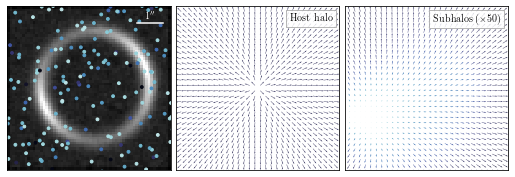

In [13]:
fig = paper_settings.grid_width(nx=3,ny=1,large_margin=0.03, small_margin=0.03, sep=0.03)
    
# Image
ax = plt.subplot(1,3,1)
im = plt.imshow(
    np.log10(x),
    vmin=2.3,
    vmax=3.15,
    cmap='gist_gray',
    extent=(-3.2,3.2,-3.2,3.2),
    origin="lower"
)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.scatter(
    xsub,
    ysub,
    s=8.,
    c=np.log10(msub/M_s),
    cmap=paper_settings.CMAP1,
    vmin=6.8,
    vmax=9.0,
)
#rect = matplotlib.patches.Rectangle((-3,-3),1.2,0.6,linewidth=0,edgecolor='black',facecolor='black', alpha=0.6)
#ax.add_patch(rect)
#plt.plot([-2.9, -1.9], [-2.9, -2.9], c="white", lw=1.5, ls="-")
#plt.text(-2.4, -2.65, '$1$"', va="center", ha="center", color="white")
plt.plot([1.9, 2.9], [2.55, 2.55], c="white", lw=1.5, ls="-")
plt.text(2.4, 2.8, "$1''$", va="center", ha="center", color="white")
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
    
# Host deflection
ax = plt.subplot(1,3,2)
plt.quiver(
    theta_x.flatten(),
    theta_y.flatten(),
    phih[0],
    phih[1],
    (phih[0]**2 + phih[1]**2)**0.5,
    scale=scale,
    cmap=paper_settings.CMAP1,
    norm=matplotlib.colors.Normalize(0.,cmax)
)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(
    2.9, 2.9, "Host halo",
    ha="right", va="top",
    bbox=dict(ec="0.65", fc="white", alpha=0.8)
)

# Sub deflection
ax = plt.subplot(1,3,3)
plt.quiver(
    theta_x.flatten(),
    theta_y.flatten(),
    phis[0],
    phis[1],
    (phis[0]**2 + phis[1]**2)**0.5,
    scale=scale/50,
    cmap=paper_settings.CMAP1,
    norm=matplotlib.colors.Normalize(0.,cmax/50)
)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(
    2.9, 2.9, r"Subhalos ($\times 50$)",
    ha="right", va="top",
    bbox=dict(ec="0.65", fc="white", alpha=0.8)
)
    
plt.savefig("../figures/deflection_maps.pdf", dpi=300)
